In [6]:
%matplotlib inline
import scipy as sp
from scipy.optimize import curve_fit 
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from astropy.io import fits
import numpy as np
from scipy.signal import argrelextrema

#When given the name for the directory of a group, and the letter used in their prefix, will compile the bias data from the bias frames they took and return an array of bias frames
def getBias(fileName, letter):
    bias = []
    for i in range(1,11):
        bias.append(fits.getdata("/Users/dlvozza/Desktop/lsa-ast361/work/dlvozza/lab4/ccd/Important_Bits/"+fileName+"/"+letter+"Bias"+str('0'*(8-len(str(i))))+"{}.fit".format(i) , ext=0).astype(np.int))
    return bias

#When given the name for the directory of a group, the letter used in their prefix, and the mean bias from their bias frames, will compile the flat data from the flat frames, subtract the average bias slice, and then return the adjusted flat slice range
def getFlats(fileName, letter, avgBias):
    flatfield = []
    for i in range(11,21):
        flatfield.append(fits.getdata("/Users/dlvozza/Desktop/lsa-ast361/work/dlvozza/lab4/ccd/Important_Bits/"+fileName+"/"+letter+"FlatField000000{}.fit".format(i) , ext=0).astype(np.int))
    adj_flatfield = [flats - avgBias for flats in flatfield]
    return adj_flatfield

#When given the starting index of a dark image set for a given temperature, will find the bias frames and dark frames taken at that temperature, subtract the mean bias from the dark, and return the mean dark value
def getDark(n):
    dark = []
    bias = []
    for i in range(1+n,3+n):
        bias.append(fits.getdata("/Users/dlvozza/Desktop/lsa-ast361/work/dlvozza/lab4/ccd/Important_Bits/Sharknado/DarkCurrentData/SBias"+str('0'*(8-len(str(i))))+"{}.fit".format(i) , ext=0).astype(np.int))
    for i in range(11+n,13+n):
        dark.append(fits.getdata("/Users/dlvozza/Desktop/lsa-ast361/work/dlvozza/lab4/ccd/Important_Bits/Sharknado/DarkCurrentData/SDark"+str('0'*(8-len(str(i))))+"{}.fit".format(i) , ext=0).astype(np.int))
    adj_dark = [darks - np.asarray(bias).mean() for darks in dark]
    meanDark = np.asarray(adj_dark).mean()
    return meanDark

#When given a data cube, will return the mean slice (mean for each pixel in an array) of the data cube
def getAvgSlice(array):
    avgSlice = np.asarray(array).mean(axis = 0)
    return avgSlice
    
#When given a data cube, will return the variance slice (variance for each pixel in an array) of the data cube
def getVarSlice(array):
    varSlice = np.asarray(array).var(axis = 0)
    return varSlice

#When given the mean slice and var slice of a data cube, will calculate the value of the gain for the photos taken
def getGainSlice(meanSlice, varSlice):
    gainSlice = meanSlice/varSlice
    return gainSlice

#When given the filename of a team and the prefix letter, will get the bias array, average bias, flat array, then return the mean adjusted flat for all these
def getMeanFlat(fileName, letter):
    bias = getBias(fileName, letter)
    avgBias = getAvgSlice(bias)
    flats = getFlats(fileName, letter, avgBias)
    avgFlats = getAvgSlice(flats)
    meanFlat = np.asarray(avgFlats).mean()
    return meanFlat

#Function used to define the linear relationship fit for the group flat vs exposure time data
def func1(x, m, b):
    return np.float64(x) * np.float64(m) + np.float64(b)

#Function used to define the relationship between temperature of CCD and dark current observed
def func2(x, a, e):
    k = 8.62*(10**(-5))
    return a*(x**(3/2))*np.exp(-e/(2*k*x))

#Find the bias and flat data for our group
bias_S = getBias("Sharknado", "S")
avgBias_S = getAvgSlice(bias_S)
flats_S = getFlats("Sharknado", "S", avgBias_S)

#find the variance and mean slice for our groups data, then calculates the gain
avgFlats_S = getAvgSlice(flats_S)
varFlats_S = getVarSlice(flats_S)
gain_S = getGainSlice(avgFlats_S, varFlats_S)

#Plots the gain slice of our groups data
plt.imshow(gain_S, vmin = 0, vmax = 5, cmap = "viridis")

ImportError: No module named scipy

[ 1.65]


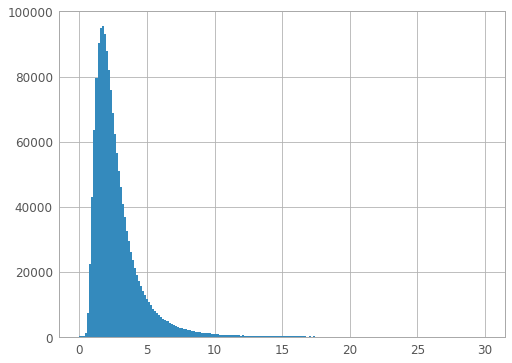

In [65]:
#plots the gain data for our group as a histogram
n, b, GainHist = plt.hist(gain_S.flatten(), 200, range = (0.0, 30.0))

#Calculates the gain for our images by finding the peak of the gain data histogram
gainMax = np.where(n == n.max())
gain = b[gainMax[0]]
print(b[gainMax[0]])

In [67]:
#calculates the read noise of the flat images taken before
Nadu = np.asarray(getVarSlice(bias_S)).mean()
print("Read Noise in ADU = " + Nadu)
Ne = gain * Nadu

print("Read Noise in e = " + Ne)

[ 55.33042999]


In [2]:
#Puts all groups into a dictionary, then iterates over that dictionary using the filename and group letter to compile flat data for all groups
groupDict = {"Group4":"a", "Mattie":"m", "Team2Awesome":"A", "Team5":"k", "TeamNot6":"Q", "Trogo":"T"}
i = 1
meanFlats = []
expTimes = [75, 150, 60, 90, 60, 100, 120]
meanFlats.append(np.asarray(avgFlats_S).mean())
for x in groupDict:
    meanFlats.append(getMeanFlat(x, groupDict[x]))
    i += 1

m, b = (1, 1)
#plots the flat data for all the groups against exposure times, then solves for a linear fit to test if our linearity prediction is accurate
fitConst, fiterr = curve_fit(func1, expTimes, meanFlats, p0=(m, b))

plt.plot(expTimes,func1(expTimes,*fitConst))
plt.scatter(expTimes, meanFlats)

NameError: name 'np' is not defined

In [ ]:
#creates an array of dark frame values based on the four images we took at teach temperature (two bias and two dark frames)
darks = []
temps = np.array([10+273.15, 6+273.15, 2+273.15, -2+273.15, -4+273.15])
for i in range(0,5):
    darks.append(getDark(2*i))
darksFinal = (darks * gain)/70 
a0,e0 = (1e7, 1)

#creates a non linear fit line based on the equation in func2, then plots the data for dark against temperature and plots the fitted curve
coeffs, fiterr = curve_fit(func2, temps, darksFinal, p0=(a0,e0))
#coeffs = [a0,e0]

plt.scatter(temps, darksFinal)
plt.plot(temps,func2(temps,*coeffs))
print(coeffs)